# Mean Modeling

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 

In [34]:
# import data
df = pd.read_csv('../data/processed/SPY_Close_modeling_2.5y.csv')
df.head()

,Date,close,log_return
0,2023-01-04,3852.97,0.007511
1,2023-01-05,3808.10,-0.011714
2,2023-01-06,3895.08,0.022584
3,2023-01-09,3892.09,-0.000768
4,2023-01-10,3919.25,0.006954


In [35]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")
df.head()

,close,log_return
Date,,
2023-01-04,3852.97,0.007511
2023-01-05,3808.10,-0.011714
2023-01-06,3895.08,0.022584
2023-01-09,3892.09,-0.000768
2023-01-10,3919.25,0.006954


### Stationary Test

In [36]:
y = df["log_return"].dropna()

adf_stat, pvalue, usedlag, nobs, crit, icbest = adfuller(y, autolag="AIC")
print("ADF statistic:", adf_stat)
print("p-value:", pvalue)
print("critical values:", crit)

if pvalue < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF statistic: -14.117207584832112
p-value: 2.460600397196491e-26
critical values: {'1%': np.float64(-3.440958441424668), '5%': np.float64(-2.86622052433566), '10%': np.float64(-2.569262629991048)}
The series is stationary.


The ADF test statistic is -14.11 with a p-value close to zero.
We reject the null hypothesis of unit root.
Therefore, the log return series is stationary.

### ACF Test 

<Figure size 640x480 with 0 Axes>

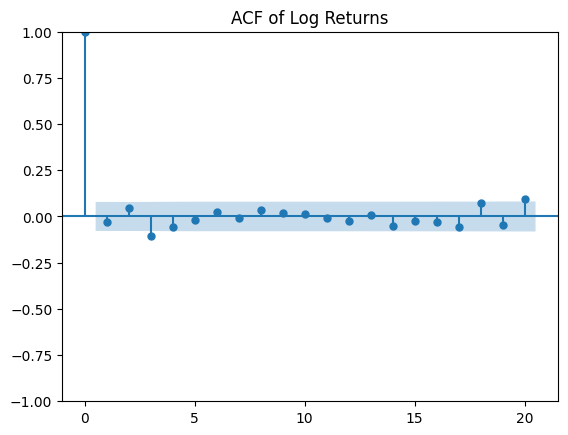

<Figure size 640x480 with 0 Axes>

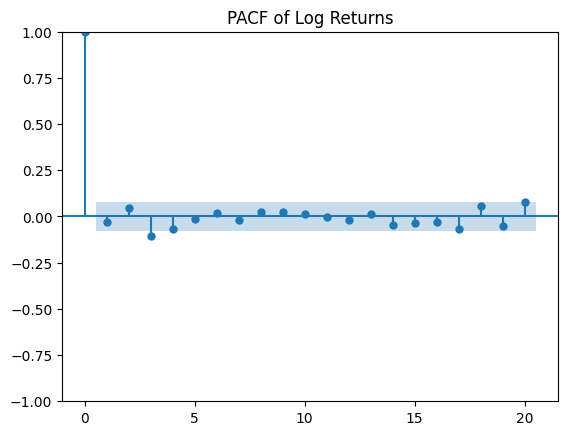

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plt.figure()
plot_acf(y, lags=20)
plt.title("ACF of Log Returns")
plt.show()

plt.figure()
plot_pacf(y, lags=20, method='ywm')
plt.title("PACF of Log Returns")
plt.show()

### Modeling

In [38]:
from statsmodels.tsa.arima.model import ARIMA

y = df["log_return"].dropna()

## Model Selection
max_p = 9
max_d =0  
max_q = 9

results = []

for p in range(0, 10):
    for q in range(0, 10):
        try:
            model = ARIMA(y, order=(p,0,q))
            fit = model.fit()

            results.append({
                "p": p,
                "d": 0,
                "q": q,
                "AIC": fit.aic,
                "BIC": fit.bic
            })
        except:
            continue

results_df = pd.DataFrame(results)

# Sort by BIC (lower is better)
results_df = results_df.sort_values("BIC").reset_index(drop=True)

print("Best models by BIC:")
print(results_df.head(10))

/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency informatio

Best models by BIC:
   p  d  q          AIC          BIC
0  0  0  0 -3975.819900 -3966.950807
1  1  0  0 -3974.476127 -3961.172488
2  0  0  1 -3974.367179 -3961.063539
3  0  0  3 -3978.786845 -3956.614113
4  3  0  0 -3978.534069 -3956.361336
5  2  0  0 -3973.727221 -3955.989035
6  0  0  2 -3973.526261 -3955.788075
7  1  0  1 -3971.820417 -3954.082231
8  4  0  0 -3979.369398 -3952.762119
9  0  0  4 -3979.200452 -3952.593173


In [39]:
# Identify the best model based on BIC
best = results_df.iloc[0]
best_order = (int(best["p"]), int(best["d"]), int(best["q"]))
print("\nBest ARIMA order by BIC:", best_order)


Best ARIMA order by BIC: (0, 0, 0)


In [40]:
best_model = ARIMA(y, order=best_order).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                  623
Model:                          ARIMA   Log Likelihood                1989.910
Date:                Sat, 14 Feb 2026   AIC                          -3975.820
Time:                        12:41:40   BIC                          -3966.951
Sample:                             0   HQIC                         -3972.373
                                - 623                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.935      0.053   -1.01e-05       0.002
sigma2      9.835e-05   1.98e-06     49.548      0.000    9.45e-05       0.000
Ljung-Box (L1) (Q):                   0.66   Jarque-

/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/TS_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We choose AR(0) as our mean model

In [41]:
# Ljung-Box test for residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = best_model.resid
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box test results:")
print(ljung_box_results)


Ljung-Box test results:
      lb_stat  lb_pvalue
10  12.869567   0.231056


H0: the residuals are white noice
p-value = 0.227067 > 0.05, cannot reject H0

There is no autocorrelation in residuals, which means mean model is a good fit. 

In [42]:
from statsmodels.stats.diagnostic import het_arch

residuals = best_model.resid

arch_test = het_arch(residuals, nlags=10)

lm_stat = arch_test[0]
lm_pvalue = arch_test[1]
f_stat = arch_test[2]
f_pvalue = arch_test[3]

print("ARCH LM Test Results")
print("LM Statistic:", lm_stat)
print("LM p-value:", lm_pvalue)
print("F Statistic:", f_stat)
print("F p-value:", f_pvalue)

ARCH LM Test Results
LM Statistic: 124.85423869140504
LM p-value: 5.221512563103674e-22
F Statistic: 15.397501658261845
F p-value: 1.0833322588663925e-24


The ARCH LM test strongly rejects the null hypothesis of no ARCH effects (LM p-value ≈ 0). This indicates the presence of significant conditional heteroskedasticity in the residuals. Therefore, the mean model alone is insufficient, and a GARCH-type model is required to properly capture volatility clustering.

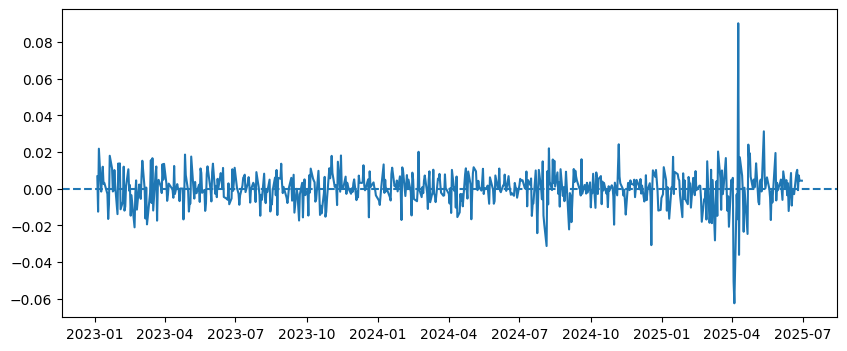

In [43]:
# Plot residuals to show volatility clustering

residuals.index = df.loc[y.index].index
plt.figure(figsize=(10,4))
plt.plot(residuals.index, residuals)

plt.axhline(0, linestyle="--")
plt.show()

The residuals fluctuate around zero, indicating that the mean dynamics have been adequately captured. However, clear volatility clustering is observed, particularly during crisis periods (e.g., 2020), suggesting time-varying conditional variance.